# CGCNN Training and Visualization

This notebook implements the complete training pipeline for **Crystal Graph Convolutional Neural Networks (CGCNN)**, a deep learning framework for predicting material properties directly from crystal structures.

## Reference
**Paper**: Xie, T., & Grossman, J. C. (2018). "Crystal Graph Convolutional Neural Networks for an Accurate and Interpretable Prediction of Material Properties." *Physical Review Letters*, 120(14), 145301.

## Overview

CGCNN treats crystal structures as graphs where:
- **Nodes**: Represent atoms in the crystal
- **Edges**: Represent interactions between neighboring atoms
- **Node Features**: Atom properties (element type, electron configuration, etc.)
- **Edge Features**: Interatomic distances encoded as Gaussian basis functions

The network learns to predict material properties (e.g., formation energy, band gap) through:
1. **Graph Construction**: Converting crystal structures to graph representations
2. **Message Passing**: Aggregating information from neighboring atoms through multiple convolutional layers
3. **Pooling**: Combining atom-level features into crystal-level representation
4. **Prediction**: Mapping crystal features to target properties

## Workflow
1. Load the dataset created in notebook 02
2. Define data loading and model architectures
3. Train the model with proper tracking and validation
4. Evaluate performance on test set
5. Visualize training progress and prediction quality
6. Save model checkpoints and results

---

## Part 1: Setup and Imports

In [19]:
# Standard library imports
import os
import csv
import json
import random
import functools
import warnings
from pathlib import Path

# Data handling
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Pymatgen
from pymatgen.core.structure import Structure
from pymatgen.core.periodic_table import Element

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

✅ All libraries imported successfully
PyTorch Version: 2.9.0+cu128
CUDA Available: True
Device: cuda


## Part 2: Configuration

In [20]:
# Dataset Configuration
DATA_DIR = os.path.join('..', 'data')
MAX_NUM_NBR = 12
RADIUS = 8.0
DMIN = 0
DSTEP = 0.2

# Data Loading Configuration
BATCH_SIZE = 4
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Model Configuration
ATOM_FEA_LEN = 64
N_CONV = 3
H_FEA_LEN = 128
N_H = 1

LEARNING_RATE = 0.1
WEIGHT_DECAY = 0.0
EPOCHS = 5
EARLY_STOPPING_PATIENCE = 30

# Output Configuration
OUTPUT_DIR = 'training_results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Configuration:")
print(f"  data Directory: {DATA_DIR}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Train/Val/Test Split: {TRAIN_RATIO}/{VAL_RATIO}/{TEST_RATIO}")
print(f"  Model: {N_CONV} conv layers, {ATOM_FEA_LEN}D atom features, {H_FEA_LEN}D hidden")
print(f"  Output Directory: {OUTPUT_DIR}")


Configuration:
  data Directory: ..\data
  Batch Size: 8
  Train/Val/Test Split: 0.7/0.15/0.15
  Model: 3 conv layers, 64D atom features, 128D hidden
  Output Directory: training_results


## Part 3: Data Loading Classes

These classes handle crystal structure loading and graph construction.

### Theoretical Background

#### 1. Gaussian Distance Expansion
Interatomic distances are encoded using **Gaussian basis functions** to create continuous, differentiable edge features:

$$
e_{ij}^k = \exp\left(-\frac{(d_{ij} - \mu_k)^2}{\sigma^2}\right)
$$

Where:
- $d_{ij}$: Distance between atoms $i$ and $j$
- $\mu_k$: Center of the $k$-th Gaussian filter
- $\sigma$: Width of the Gaussian (controls smoothness)

This expansion converts a single distance value into a vector of features, allowing the network to learn distance-dependent interactions.

#### 2. Atom Feature Initialization
Each atom is represented by a learnable feature vector based on its element type. These initial features capture:
- Element properties (atomic number, electronegativity, etc.)
- Electron configuration
- Chemical characteristics

#### 3. Crystal Graph Dataset
The dataset loads crystal structures from CIF (Crystallographic Information File) format and constructs graph representations:
- **Input**: CIF files + target properties (e.g., formation energy)
- **Output**: Graph tuple (atom_features, edge_features, edge_indices) + target value

#### 4. Batching Strategy
Since crystals have varying numbers of atoms, we use a custom collating function that:
1. Concatenates all atoms from different crystals into a single large graph
2. Maintains indices to track which atoms belong to which crystal
3. Enables efficient batch processing on GPU

In [21]:
class GaussianDistance(object):
    """
    Expands interatomic distances using Gaussian basis functions.
    
    This class converts scalar distances into vector representations by applying
    multiple Gaussian filters centered at different positions along the distance range.
    
    Mathematical Formulation:
        g_k(d) = exp(-(d - μ_k)^2 / σ^2)
    
    where:
        - d: interatomic distance
        - μ_k: center of k-th Gaussian filter
        - σ: width (standard deviation) of Gaussian
    
    Parameters
    ----------
    dmin : float
        Minimum distance for Gaussian filters
    dmax : float
        Maximum distance for Gaussian filters
    step : float
        Spacing between adjacent Gaussian filter centers
    var : float, optional
        Variance of Gaussian filters. If None, defaults to step size.
    
    Attributes
    ----------
    filter : np.ndarray
        Array of Gaussian filter centers, shape (n_filters,)
    var : float
        Standard deviation of Gaussian filters
    
    Example
    -------
    >>> gdf = GaussianDistance(dmin=0, dmax=8, step=0.2)
    >>> distances = np.array([2.5, 3.0, 4.5])  # Shape: (3,)
    >>> expanded = gdf.expand(distances)       # Shape: (3, 41)
    """
    def __init__(self, dmin, dmax, step, var=None):
        assert dmin < dmax
        assert dmax - dmin > step
        self.filter = np.arange(dmin, dmax+step, step)  # 1D array of "center" points
        if var is None:
            var = step
        self.var = var

    def expand(self, distances):
        """
        Apply Gaussian distance filter to distance array.
        
        Parameters
        ----------
        distances : np.ndarray
            Array of interatomic distances, shape (..., )
        
        Returns
        -------
        np.ndarray
            Gaussian-expanded features, shape (..., n_filters)
            where n_filters = len(self.filter)
        """
        diff = distances[..., np.newaxis] - self.filter  # Shape (..., n_filters)
        squared_diff = diff ** 2
        var_squared = self.var ** 2
        result = np.exp(-squared_diff / var_squared)
        return result

class AtomInitializer(object):
    """
    Base class for initializing atom feature vectors.
    
    This class maintains a mapping from atom types (typically atomic numbers)
    to their corresponding feature vectors. Subclasses implement specific
    initialization strategies (e.g., from JSON files, random initialization).
    
    Parameters
    ----------
    atom_types : set or list
        Set of atom types (e.g., atomic numbers) present in the dataset
    
    Attributes
    ----------
    atom_types : set
        Set of valid atom types
    _embedding : dict
        Dictionary mapping atom types to feature vectors
    """
    def __init__(self, atom_types):
        self.atom_types = set(atom_types)
        self._embedding = {}

    def get_atom_fea(self, atom_type):
        """
        Retrieve feature vector for a specific atom type.
        
        Parameters
        ----------
        atom_type : int or str
            Atom type identifier (e.g., atomic number)
        
        Returns
        -------
        np.ndarray
            Feature vector for the atom type
        """
        assert atom_type in self.atom_types
        return self._embedding[atom_type]

    def load_state_dict(self, state_dict):
        """Load atom embeddings from a state dictionary."""
        self._embedding = state_dict
        self.atom_types = set(self._embedding.keys())

    def state_dict(self):
        """Return the current embedding dictionary."""
        return self._embedding

class AtomCustomJSONInitializer(AtomInitializer):
    """
    Initialize atom features from a JSON file.
    
    Loads pre-computed atom embeddings from a JSON file that maps element
    symbols or atomic numbers to feature vectors. These embeddings can
    encode various atomic properties like electronegativity, ionic radius,
    electron affinity, etc.
    
    Parameters
    ----------
    elem_embedding_file : str
        Path to JSON file containing element embeddings
        Format: {element_id: [feature1, feature2, ...], ...}
        where element_id can be atomic number (int) or symbol (str)
    
    Example JSON Structure
    ----------------------
    {
        "1": [1.0, 0.5, ...],    # Hydrogen (by atomic number)
        "H": [1.0, 0.5, ...],    # Hydrogen (by symbol)
        "6": [2.55, 0.7, ...],   # Carbon
        ...
    }
    
    Notes
    -----
    - Automatically converts element symbols to atomic numbers
    - Handles both string and integer keys in JSON
    - Feature vectors are converted to numpy arrays with dtype=float
    """
    def __init__(self, elem_embedding_file):
        with open(elem_embedding_file) as f:
            elem_embedding = json.load(f)
        
        converted_embedding = {}
        for key, value in elem_embedding.items():
            try:
                atomic_num = int(key)
            except ValueError:
                try:
                    atomic_num = Element(key).Z
                except Exception as e:
                    print(f"Warning: Could not process element '{key}': {e}")
                    continue
            converted_embedding[atomic_num] = value
        
        atom_types = set(converted_embedding.keys())
        super(AtomCustomJSONInitializer, self).__init__(atom_types)
        
        for key, value in converted_embedding.items():
            self._embedding[key] = np.array(value, dtype=float)

class CIFData(Dataset):
    """
    PyTorch Dataset for crystal structures stored as CIF files.
    
    This dataset loads crystal structures from CIF files and converts them
    into graph representations suitable for CGCNN. Each crystal is represented
    as a graph where atoms are nodes and edges connect atoms within a cutoff radius.
    
    Directory Structure Expected
    -----------------------------
    data(..)
    ├── cgcnn_dataset.csv    # CSV with material_id,cif_file,formula,formation_energy_per_atom,energy_above_hull,band_gap,density,volume,target
    ├── atom_embedding.json  # JSON with atom feature embeddings
    ├── cif/                 # Folder containing CIF files
    │   ├── material1.cif    # CIF file for material 1
    │   ├── material2.cif    # CIF file for material 2
    │   └── ...
    
    Parameters
    ----------
    root_dir : str
        Path to directory containing CIF folder having cif id data and metadata
    max_num_nbr : int, default=12
        Maximum number of neighbors to consider for each atom
    radius : float, default=8
        Cutoff radius (Angstroms) for neighbor search
    dmin : float, default=0
        Minimum distance for Gaussian expansion
    step : float, default=0.2
        Step size for Gaussian filter centers
    random_seed : int, default=123
        Random seed for shuffling dataset
    
    Attributes
    ----------
    root_dir : str
        Root directory path
    max_num_nbr : int
        Maximum neighbors per atom
    radius : float
        Neighbor search cutoff radius
    ari : AtomCustomJSONInitializer
        Atom feature initializer
    gdf : GaussianDistance
        Gaussian distance expansion object
    id_prop_data : list
        List of [material_id, target_value] pairs
    
    Returns (via __getitem__)
    --------------------------
    tuple : ((atom_fea, nbr_fea, nbr_fea_idx), target, cif_id)
        atom_fea : torch.Tensor, shape (n_atoms, atom_fea_len)
            Atom feature matrix
        nbr_fea : torch.Tensor, shape (n_atoms, max_num_nbr, nbr_fea_len)
            Neighbor feature tensor (Gaussian-expanded distances)
        nbr_fea_idx : torch.LongTensor, shape (n_atoms, max_num_nbr)
            Neighbor indices for each atom
        target : torch.Tensor, shape (1,)
            Target property value
        cif_id : str
            Material identifier
    
    Example
    -------
    >>> dataset = CIFData('path/to/data/cif', max_num_nbr=12, radius=8.0)
    >>> (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id = dataset[0]
    >>> print(f"Crystal {cif_id} has {atom_fea.shape[0]} atoms")
    >>> print(f"Target property: {target.item():.4f}")
    """
    def __init__(self, root_dir, max_num_nbr=12, radius=8, dmin=0, step=0.2, random_seed=123):
        self.root_dir = root_dir
        self.max_num_nbr, self.radius = max_num_nbr, radius
        
        assert os.path.exists(root_dir), f'root_dir does not exist: {root_dir}'

        id_prop_file = os.path.join(self.root_dir,'cgcnn_dataset.csv')
        assert os.path.exists(id_prop_file), f'cgcnn_dataset.csv not found at {id_prop_file}'

        with open(id_prop_file) as f:
            reader = csv.reader(f)
            # skip header
            header = next(reader)
            self.id_prop_data = [(row[0], float(row[3])) for row in reader]
        random.seed(random_seed)
        random.shuffle(self.id_prop_data)
        
        # Load atom embeddings from atom_embedding.json in root_dir
        atom_init_file = os.path.join(self.root_dir, 'atom_embedding.json')
        assert os.path.exists(atom_init_file), f'atom_embedding.json not found at {atom_init_file}'
        
        self.ari = AtomCustomJSONInitializer(atom_init_file)
        self.gdf = GaussianDistance(dmin=dmin, dmax=self.radius, step=step)

    def __len__(self):
        """Return the number of crystals in the dataset."""
        return len(self.id_prop_data)

    @functools.lru_cache(maxsize=None)
    def __getitem__(self, idx):
        """
        Get a single crystal graph and its target property.
        
        Parameters
        ----------
        idx : int
            Index of the crystal in the dataset
        
        Returns
        -------
        tuple : ((atom_fea, nbr_fea, nbr_fea_idx), target, cif_id)
            Graph representation and target value
        
        Notes
        -----
        - Uses LRU cache to avoid reloading the same crystal multiple times
        - Pads neighbor lists to max_num_nbr if insufficient neighbors found
        - Applies Gaussian expansion to neighbor distances
        """
        cif_id, target = self.id_prop_data[idx]
        # Look for CIF file in cif subdirectory
        cif_path = os.path.join(self.root_dir, 'cif', cif_id+'.cif')
        crystal = Structure.from_file(cif_path)
        
        # Get atom features
        atom_fea = np.vstack([self.ari.get_atom_fea(crystal[i].specie.number)
                              for i in range(len(crystal))])
        atom_fea = torch.Tensor(atom_fea)
        
        # Get neighbors within cutoff radius
        all_nbrs = crystal.get_all_neighbors(self.radius, include_index=True)
        all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]
        
        # Build neighbor arrays
        nbr_fea_idx, nbr_fea = [], []
        for nbr in all_nbrs:
            if len(nbr) < self.max_num_nbr:
                warnings.warn(f'{cif_id}: not enough neighbors')
                nbr_fea_idx.append(list(map(lambda x: x[2], nbr)) + [0] * (self.max_num_nbr - len(nbr)))
                nbr_fea.append(list(map(lambda x: x[1], nbr)) + [self.radius + 1.] * (self.max_num_nbr - len(nbr)))
            else:
                nbr_fea_idx.append(list(map(lambda x: x[2], nbr[:self.max_num_nbr])))
                nbr_fea.append(list(map(lambda x: x[1], nbr[:self.max_num_nbr])))
        
        nbr_fea_idx, nbr_fea = np.array(nbr_fea_idx), np.array(nbr_fea)
        nbr_fea = self.gdf.expand(nbr_fea)
        
        return (torch.Tensor(atom_fea), torch.Tensor(nbr_fea), torch.LongTensor(nbr_fea_idx)), \
               torch.Tensor([float(target)]), cif_id

def collate_pool(dataset_list):
    """
    Collate function for batching variable-sized crystal graphs.
    
    This function merges multiple crystals into a single large graph by:
    1. Concatenating all atom features
    2. Concatenating all neighbor features
    3. Adjusting neighbor indices to account for the combined graph
    4. Maintaining mappings from crystals to their constituent atoms
    
    Theoretical Background
    ----------------------
    Since crystals have different numbers of atoms, we cannot simply stack them
    into a tensor. Instead, we create a "batch graph" by concatenating all atoms
    and tracking which atoms belong to which crystal. This allows efficient
    parallel processing on GPU while handling variable-sized inputs.
    
    Parameters
    ----------
    dataset_list : list of tuples
        List of dataset items, where each item is:
        ((atom_fea, nbr_fea, nbr_fea_idx), target, cif_id)
    
    Returns
    -------
    tuple : ((batch_atom_fea, batch_nbr_fea, batch_nbr_fea_idx, crystal_atom_idx), 
             batch_target, batch_cif_ids)
        
        batch_atom_fea : torch.Tensor, shape (total_atoms, atom_fea_len)
            Concatenated atom features from all crystals in batch
        
        batch_nbr_fea : torch.Tensor, shape (total_atoms, max_num_nbr, nbr_fea_len)
            Concatenated neighbor features
        
        batch_nbr_fea_idx : torch.LongTensor, shape (total_atoms, max_num_nbr)
            Concatenated and adjusted neighbor indices
        
        crystal_atom_idx : list of torch.LongTensor
            List where crystal_atom_idx[i] contains indices of atoms
            belonging to crystal i in the batch
        
        batch_target : torch.Tensor, shape (batch_size, 1)
            Stacked target values
        
        batch_cif_ids : list of str
            Material identifiers
    
    Example
    -------
    Suppose we have 2 crystals:
    - Crystal A: 10 atoms (indices 0-9 in batch)
    - Crystal B: 15 atoms (indices 10-24 in batch)
    
    Then crystal_atom_idx = [
        torch.LongTensor([0,1,2,3,4,5,6,7,8,9]),      # Crystal A
        torch.LongTensor([10,11,12,13,14,15,...,24])  # Crystal B
    ]
    """
    batch_atom_fea, batch_nbr_fea, batch_nbr_fea_idx = [], [], []
    crystal_atom_idx, batch_target = [], []
    batch_cif_ids = []
    base_idx = 0
    
    for i, ((atom_fea, nbr_fea, nbr_fea_idx), target, cif_id) in enumerate(dataset_list):
        n_i = atom_fea.shape[0]  # Number of atoms in this crystal
        batch_atom_fea.append(atom_fea)
        batch_nbr_fea.append(nbr_fea)
        batch_nbr_fea_idx.append(nbr_fea_idx + base_idx)  # Adjust indices
        
        new_idx = torch.LongTensor(np.arange(n_i) + base_idx)
        crystal_atom_idx.append(new_idx)
        batch_target.append(target)
        batch_cif_ids.append(cif_id)
        base_idx += n_i
    
    return (torch.cat(batch_atom_fea, dim=0),
            torch.cat(batch_nbr_fea, dim=0),
            torch.cat(batch_nbr_fea_idx, dim=0),
            crystal_atom_idx), \
           torch.stack(batch_target, dim=0), \
           batch_cif_ids

def get_train_val_test_loader(dataset, collate_fn=default_collate,
                              batch_size=64, train_ratio=None,
                              val_ratio=0.1, test_ratio=0.1, return_test=False,
                              num_workers=0, pin_memory=False, **kwargs):
    """
    Create train, validation, and test data loaders with proper splitting.
    
    Splits the dataset into training, validation, and test sets, and creates
    PyTorch DataLoader objects for each. Uses SubsetRandomSampler to ensure
    consistent splits across epochs.
    
    Parameters
    ----------
    dataset : Dataset
        PyTorch dataset to split
    collate_fn : callable, default=default_collate
        Function to merge list of samples into mini-batch
        For CGCNN, should be collate_pool
    batch_size : int, default=64
        Number of crystals per batch
    train_ratio : float, optional
        Fraction of data for training. If None, computed as 1 - val - test
    val_ratio : float, default=0.1
        Fraction of data for validation
    test_ratio : float, default=0.1
        Fraction of data for testing
    return_test : bool, default=False
        Whether to return test loader
    num_workers : int, default=0
        Number of subprocesses for data loading (0 = main process only)
    pin_memory : bool, default=False
        If True, DataLoader will copy tensors into CUDA pinned memory
    **kwargs : dict
        Additional arguments (train_size, val_size, test_size can override ratios)
    
    Returns
    -------
    tuple
        (train_loader, val_loader) if return_test=False
        (train_loader, val_loader, test_loader) if return_test=True
    
    Notes
    -----
    - Data is split sequentially (not random), so shuffle your dataset first
    - Samplers use indices to select subsets without copying data
    - pin_memory=True can speed up CPU->GPU transfer but uses more memory
    
    Example
    -------
    >>> train_loader, val_loader, test_loader = get_train_val_test_loader(
    ...     dataset, collate_fn=collate_pool, batch_size=32,
    ...     train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, return_test=True
    ... )
    """
    total_size = len(dataset)
    if train_ratio is None:
        train_ratio = 1 - val_ratio - test_ratio
    
    indices = list(range(total_size))
    train_size = int(train_ratio * total_size)
    test_size = int(test_ratio * total_size)
    valid_size = int(val_ratio * total_size)
    
    train_sampler = SubsetRandomSampler(indices[:train_size])
    val_sampler = SubsetRandomSampler(indices[-(valid_size + test_size):-test_size])
    
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler,
                              num_workers=num_workers, collate_fn=collate_fn, pin_memory=pin_memory)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler,
                            num_workers=num_workers, collate_fn=collate_fn, pin_memory=pin_memory)
    
    if return_test:
        test_sampler = SubsetRandomSampler(indices[-test_size:])
        test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler,
                                 num_workers=num_workers, collate_fn=collate_fn, pin_memory=pin_memory)
        return train_loader, val_loader, test_loader
    return train_loader, val_loader


## Part 4: Load Dataset and Create Data Loaders

### What Happens Here

This section:
1. **Loads the crystal dataset** from CIF files created in notebook 02
2. **Extracts feature dimensions** needed to initialize the model
3. **Creates data loaders** for efficient batch processing during training

### Key Information Extracted

- **ORIG_ATOM_FEA_LEN**: Dimension of input atom features (depends on atom_init.json)
- **NBR_FEA_LEN**: Dimension of edge features (= number of Gaussian filters)
  - Computed as: `(radius - dmin) / step + 1`
  - Example: `(8.0 - 0) / 0.2 + 1 = 41`

### Data Split Strategy

```
Total Dataset (100%)
    ├── Training Set (70%) → Used for weight updates
    ├── Validation Set (15%) → Used for hyperparameter tuning
    └── Test Set (15%) → Final performance evaluation
```

**Important**: Test set is never used during training or model selection!

In [22]:
# Test GaussianDistance class
print("\n" + "="*80)
print("Testing GaussianDistance Function")
print("="*80)
gdf_test = GaussianDistance(dmin=DMIN, dmax=RADIUS, step=DSTEP)
print(f"✅ GaussianDistance initialized:")
print(f"   Filter centers: {len(gdf_test.filter)} points")
print(f"   Distance range: {DMIN} to {RADIUS} Å")
print(f"   Step size: {DSTEP} Å")
print(f"   Variance: {gdf_test.var}")

# Test with sample distances
sample_distances = np.array([2.5, 3.0, 4.5, 5.5])
expanded_features = gdf_test.expand(sample_distances)
print(f"\n   Sample distances: {sample_distances}")
print(f"   Expanded shape: {expanded_features.shape}")
print(f"   Sample expanded features (first distance):\n{expanded_features[0, :5]}")

# Load dataset using CIFData class
print("\n" + "="*80)
print("Loading Dataset with CIFData Class")
print("="*80)
dataset = CIFData(
    root_dir=DATA_DIR,
    max_num_nbr=MAX_NUM_NBR,
    radius=RADIUS,
    dmin=DMIN,
    step=DSTEP,
    random_seed=RANDOM_SEED
)

print(f"✅ Dataset loaded successfully:")
print(f"   Total crystals: {len(dataset)}")

# Get first sample to verify structure
(atom_fea, nbr_fea, nbr_fea_idx), target, cif_id = dataset[0]
ORIG_ATOM_FEA_LEN = atom_fea.shape[1]
NBR_FEA_LEN = nbr_fea.shape[2]

print(f"   First crystal: {cif_id}")
print(f"   Number of atoms: {atom_fea.shape[0]}")
print(f"   Atom feature dimension: {ORIG_ATOM_FEA_LEN}")
print(f"   Max neighbors: {nbr_fea.shape[1]}")
print(f"   Neighbor feature dimension: {NBR_FEA_LEN}")
print(f"   Target property value: {target.item():.6f}")

# Create data loaders using get_train_val_test_loader
print("\n" + "="*80)
print("Creating Data Loaders with get_train_val_test_loader")
print("="*80)
train_loader, val_loader, test_loader = get_train_val_test_loader(
    dataset=dataset,
    collate_fn=collate_pool,
    batch_size=BATCH_SIZE,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    return_test=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

print(f"✅ Data loaders created successfully:")
print(f"   Training batches: {len(train_loader)}")
print(f"   Training samples: {len(train_loader.dataset)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Validation samples: {len(val_loader.dataset)}")
print(f"   Test batches: {len(test_loader)}")
print(f"   Test samples: {len(test_loader.dataset)}")

# Test collate_pool function with first batch
print("\n" + "="*80)
print("Testing collate_pool Function")
print("="*80)
first_batch = next(iter(train_loader))
(batch_atom_fea, batch_nbr_fea, batch_nbr_fea_idx, crystal_atom_idx), batch_target, batch_cif_ids = first_batch

print(f"✅ Batch collated successfully:")
print(f"   Batch atom features shape: {batch_atom_fea.shape}")
print(f"   Batch neighbor features shape: {batch_nbr_fea.shape}")
print(f"   Batch neighbor indices shape: {batch_nbr_fea_idx.shape}")
print(f"   Number of crystals in batch: {len(crystal_atom_idx)}")
print(f"   Crystal atom indices (first crystal): {crystal_atom_idx[0]}")
print(f"   Batch target shape: {batch_target.shape}")
print(f"   Batch material IDs: {batch_cif_ids[:3]}...")  # Show first 3

# Save data loading summary
print("\n" + "="*80)
print("Saving Data Loading Summary")
print("="*80)

data_summary = {
    'GaussianDistance': {
        'filter_centers': len(gdf_test.filter),
        'distance_range': f'{DMIN} to {RADIUS} Å',
        'step_size': DSTEP,
        'variance': gdf_test.var
    },
    'Dataset': {
        'total_samples': len(dataset),
        'atom_feature_dimension': ORIG_ATOM_FEA_LEN,
        'neighbor_feature_dimension': NBR_FEA_LEN,
        'max_neighbors': MAX_NUM_NBR,
        'radius_cutoff': RADIUS
    },
    'DataLoaders': {
        'batch_size': BATCH_SIZE,
        'train_ratio': TRAIN_RATIO,
        'val_ratio': VAL_RATIO,
        'test_ratio': TEST_RATIO,
        'train_batches': len(train_loader),
        'val_batches': len(val_loader),
        'test_batches': len(test_loader),
        'train_samples': len(train_loader.dataset),
        'val_samples': len(val_loader.dataset),
        'test_samples': len(test_loader.dataset)
    },
    'FirstSample': {
        'material_id': cif_id,
        'num_atoms': int(atom_fea.shape[0]),
        'target_value': float(target.item()),
        'atom_fea_shape': list(atom_fea.shape),
        'nbr_fea_shape': list(nbr_fea.shape),
        'nbr_fea_idx_shape': list(nbr_fea_idx.shape)
    }
}

# Save to JSON
with open(os.path.join(OUTPUT_DIR, 'data_loading_summary.json'), 'w') as f:
    json.dump(data_summary, f, indent=2)

# Save to CSV
summary_df = pd.DataFrame({
    'Component': ['GaussianDistance', 'Dataset', 'DataLoaders', 'FirstSample'],
    'Key_Information': [
        f"Filters: {len(gdf_test.filter)}, Range: {DMIN}-{RADIUS}Å, Variance: {gdf_test.var}",
        f"Samples: {len(dataset)}, Atom Features: {ORIG_ATOM_FEA_LEN}, Neighbor Features: {NBR_FEA_LEN}",
        f"Train: {len(train_loader)} batches ({len(train_loader.dataset)} samples), Val: {len(val_loader)} batches ({len(val_loader.dataset)} samples), Test: {len(test_loader)} batches ({len(test_loader.dataset)} samples)",
        f"Crystal: {cif_id}, Atoms: {atom_fea.shape[0]}, Target: {target.item():.6f}"
    ]
})
summary_df.to_csv(os.path.join(OUTPUT_DIR, 'data_loading_summary.csv'), index=False)

print(f"✅ Saved to:")
print(f"   {os.path.join(OUTPUT_DIR, 'data_loading_summary.json')}")
print(f"   {os.path.join(OUTPUT_DIR, 'data_loading_summary.csv')}")

print("\n" + "="*80)
print("Data Loading Pipeline Complete!")
print("="*80)



Testing GaussianDistance Function
✅ GaussianDistance initialized:
   Filter centers: 41 points
   Distance range: 0 to 8.0 Å
   Step size: 0.2 Å
   Variance: 0.2

   Sample distances: [2.5 3.  4.5 5.5]
   Expanded shape: (4, 41)
   Sample expanded features (first distance):
[1.38511937e-68 3.66905962e-58 1.31532589e-48 6.38150345e-40
 4.19009319e-32]

Loading Dataset with CIFData Class
✅ Dataset loaded successfully:
   Total crystals: 103644
   First crystal: mp-1229074
   Number of atoms: 60
   Atom feature dimension: 186
   Max neighbors: 12
   Neighbor feature dimension: 41
   Target property value: -1.964300

Creating Data Loaders with get_train_val_test_loader
✅ Data loaders created successfully:
   Training batches: 9069
   Training samples: 103644
   Validation batches: 1944
   Validation samples: 103644
   Test batches: 1944
   Test samples: 103644

Testing collate_pool Function


C:\Users\abhin\Desktop\cgcnn\.venv\Lib\site-packages\pymatgen\core\structure.py:3109: UserWarning: Issues encountered while parsing CIF: 36 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
C:\Users\abhin\Desktop\cgcnn\.venv\Lib\site-packages\pymatgen\core\structure.py:3109: UserWarning: Issues encountered while parsing CIF: 12 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
C:\Users\abhin\Desktop\cgcnn\.venv\Lib\site-packages\pymatgen\core\structure.py:3109: UserWarning: Issues encountered while parsing CIF: 16 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]


✅ Batch collated successfully:
   Batch atom features shape: torch.Size([293, 186])
   Batch neighbor features shape: torch.Size([293, 12, 41])
   Batch neighbor indices shape: torch.Size([293, 12])
   Number of crystals in batch: 8
   Crystal atom indices (first crystal): tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])
   Batch target shape: torch.Size([8, 1])
   Batch material IDs: ['mp-1208706', 'mp-721017', 'mp-5454']...

Saving Data Loading Summary
✅ Saved to:
   training_results\data_loading_summary.json
   training_results\data_loading_summary.csv

Data Loading Pipeline Complete!


## Part 5: CGCNN Model Definition

### Theoretical Background

#### Graph Convolution on Crystals

The CGCNN architecture implements a **message passing neural network** that operates on crystal graphs. The key innovation is adapting convolutional operations to work on irregular graph structures.

#### Convolution Layer Mathematics

For each atom $i$, the convolution operation aggregates information from its neighbors $\mathcal{N}(i)$:

$$
\mathbf{v}_i^{(t+1)} = \mathbf{v}_i^{(t)} + \sum_{j \in \mathcal{N}(i)} \sigma\left(\mathbf{z}_{ij}^{(t)}\right) \odot \mathbf{g}\left(\mathbf{z}_{ij}^{(t)}\right)
$$

Where:
- $\mathbf{v}_i^{(t)}$ : Feature vector of atom $i$ at layer $t$
- $\mathbf{z}_{ij}^{(t)} = [\mathbf{v}_i^{(t)} \oplus \mathbf{v}_j^{(t)} \oplus \mathbf{u}_{ij}]$ : Concatenation of center atom, neighbor, and edge features
- $\sigma$ : Sigmoid gate function (controls information flow)
- $\mathbf{g}$ : Core message function (softplus activation)
- $\odot$ : Element-wise multiplication

#### Network Architecture

```
Crystal Structure (CIF)
    ↓
[Atom Features + Edge Features]
    ↓
Embedding Layer → Hidden dimension
    ↓
Conv Layer 1 → Message passing iteration 1
    ↓
Conv Layer 2 → Message passing iteration 2
    ↓
    ...
    ↓
Conv Layer n → Message passing iteration n
    ↓
Pooling Layer → Mean over all atoms per crystal
    ↓
Fully Connected Layers → Property-specific features
    ↓
Output Layer → Predicted property value
```

#### Key Components

1. **ConvLayer**: Graph convolution with gating mechanism
   - Input: Atom features, neighbor features, neighbor indices
   - Output: Updated atom features
   
2. **CrystalGraphConvNet**: Complete CGCNN model
   - Embedding: Projects initial atom features to hidden space
   - Multiple ConvLayers: Stack of graph convolutions
   - Pooling: Aggregates atom-level → crystal-level features
   - FC layers: Maps to target property

#### Gating Mechanism

The sigmoid gate $\sigma$ acts as an attention mechanism, learning which neighbor information is most relevant:
- Gate value ≈ 0: Neighbor has little influence
- Gate value ≈ 1: Neighbor has strong influence

This allows the network to focus on chemically important interactions.

In [23]:
class ConvLayer(nn.Module):
    """
    Graph convolutional layer for crystal structures.
    
    Implements the message passing convolution operation that aggregates
    information from neighboring atoms using a gating mechanism. This layer
    is the core building block of CGCNN.
    
    Mathematical Formulation
    ------------------------
    For each atom i with neighbors j ∈ N(i):
    
    1. Concatenate features: z_ij = [v_i || v_j || u_ij]
    2. Linear transformation: h_ij = W * z_ij + b
    3. Split into gate and core: f_ij, c_ij = split(BN(h_ij))
    4. Apply activations: f_ij = sigmoid(f_ij), c_ij = softplus(c_ij)
    5. Gated aggregation: m_i = Σ_j (f_ij ⊙ c_ij)
    6. Residual update: v_i' = softplus(v_i + BN(m_i))
    
    where:
        v_i: central atom features
        v_j: neighbor atom features
        u_ij: edge features (bond information)
        ||: concatenation
        ⊙: element-wise multiplication
        BN: batch normalization
    
    Parameters
    ----------
    atom_fea_len : int
        Dimension of atom feature vectors
    nbr_fea_len : int
        Dimension of neighbor (edge) feature vectors
    
    Attributes
    ----------
    fc_full : nn.Linear
        Fully connected layer mapping concatenated features to gated features
        Input: (2*atom_fea_len + nbr_fea_len)
        Output: 2*atom_fea_len (split into filter and core)
    sigmoid : nn.Sigmoid
        Gate activation function (range: 0 to 1)
    softplus1, softplus2 : nn.Softplus
        Smooth approximation of ReLU for non-linear activations
    bn1, bn2 : nn.BatchNorm1d
        Batch normalization layers for training stability
    
    Input Shape
    -----------
    atom_in_fea : torch.Tensor, shape (N, atom_fea_len)
        Atom features before convolution
    nbr_fea : torch.Tensor, shape (N, M, nbr_fea_len)
        Neighbor features (edge features)
    nbr_fea_idx : torch.LongTensor, shape (N, M)
        Indices of neighbors for each atom
        
    where:
        N = total number of atoms in batch
        M = maximum number of neighbors per atom
    
    Output Shape
    ------------
    atom_out_fea : torch.Tensor, shape (N, atom_fea_len)
        Updated atom features after convolution
    
    Example
    -------
    >>> conv = ConvLayer(atom_fea_len=64, nbr_fea_len=41)
    >>> atom_fea = torch.randn(100, 64)  # 100 atoms
    >>> nbr_fea = torch.randn(100, 12, 41)  # each atom has 12 neighbors
    >>> nbr_idx = torch.randint(0, 100, (100, 12))
    >>> atom_fea_updated = conv(atom_fea, nbr_fea, nbr_idx)
    >>> print(atom_fea_updated.shape)  # torch.Size([100, 64])
    """
    def __init__(self, atom_fea_len, nbr_fea_len):
        super(ConvLayer, self).__init__()
        self.atom_fea_len = atom_fea_len
        self.nbr_fea_len = nbr_fea_len
        
        self.fc_full = nn.Linear(2*self.atom_fea_len+self.nbr_fea_len, 2*self.atom_fea_len)
        self.sigmoid = nn.Sigmoid()
        self.softplus1 = nn.Softplus()
        self.softplus2 = nn.Softplus()
        self.bn1 = nn.BatchNorm1d(2*self.atom_fea_len)
        self.bn2 = nn.BatchNorm1d(self.atom_fea_len)

    def forward(self, atom_in_fea, nbr_fea, nbr_fea_idx):
        """
        Forward pass through the graph convolutional layer.
        
        Parameters
        ----------
        atom_in_fea : torch.Tensor, shape (N, atom_fea_len)
            Input atom features
        nbr_fea : torch.Tensor, shape (N, M, nbr_fea_len)
            Neighbor edge features
        nbr_fea_idx : torch.LongTensor, shape (N, M)
            Neighbor indices
        
        Returns
        -------
        torch.Tensor, shape (N, atom_fea_len)
            Updated atom features after message passing
        """
        N, M = nbr_fea_idx.shape
        
        # Gather neighbor atom features
        atom_nbr_fea = atom_in_fea[nbr_fea_idx, :]
        
        # Concatenate: [central_atom || neighbor_atom || edge]
        total_nbr_fea = torch.cat(
            [atom_in_fea.unsqueeze(1).expand(N, M, self.atom_fea_len),
             atom_nbr_fea, nbr_fea], dim=2)
        
        # Linear transformation + batch norm
        total_gated_fea = self.fc_full(total_nbr_fea)
        total_gated_fea = self.bn1(total_gated_fea.view(-1, self.atom_fea_len*2)).view(N, M, self.atom_fea_len*2)
        
        # Split into filter (gate) and core (message)
        nbr_filter, nbr_core = total_gated_fea.chunk(2, dim=2)
        
        # Apply activations
        nbr_filter = self.sigmoid(nbr_filter)    # Gate: 0 to 1
        nbr_core = self.softplus1(nbr_core)      # Message: >= 0
        
        # Gated aggregation: sum over neighbors
        nbr_sumed = torch.sum(nbr_filter * nbr_core, dim=1)
        nbr_sumed = self.bn2(nbr_sumed)
        
        # Residual connection + activation
        out = self.softplus2(atom_in_fea + nbr_sumed)
        
        return out


class CrystalGraphConvNet(nn.Module):
    """
    Crystal Graph Convolutional Neural Network for material property prediction.
    
    This model implements the CGCNN architecture described in:
    Xie & Grossman (2018), Physical Review Letters, 120(14), 145301.
    
    The network processes crystal structures as graphs and predicts material
    properties through a series of graph convolutions followed by pooling and
    fully connected layers.
    
    Architecture Flow
    -----------------
    Input: Crystal graph (atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx)
        ↓
    Embedding Layer: orig_atom_fea_len → atom_fea_len
        ↓
    Conv Layer 1: Graph convolution with message passing
        ↓
    Conv Layer 2: Graph convolution with message passing
        ↓
    ... (n_conv layers total)
        ↓
    Pooling: Atom-level → Crystal-level (mean pooling)
        ↓
    FC Layer: atom_fea_len → h_fea_len
        ↓
    [Optional: Additional FC layers]
        ↓
    Output Layer: h_fea_len → 1 (regression) or 2 (classification)
    
    Parameters
    ----------
    orig_atom_fea_len : int
        Dimension of input atom features (e.g., 92 for one-hot encoding)
    nbr_fea_len : int
        Dimension of edge features (e.g., 41 for Gaussian expansion)
    atom_fea_len : int, default=64
        Hidden dimension for atom features in conv layers
    n_conv : int, default=3
        Number of graph convolutional layers
    h_fea_len : int, default=128
        Dimension of hidden features after pooling
    n_h : int, default=1
        Number of hidden fully connected layers after pooling
    classification : bool, default=False
        If True, performs classification; if False, performs regression
    
    Attributes
    ----------
    embedding : nn.Linear
        Projects input atom features to hidden dimension
    convs : nn.ModuleList
        List of graph convolutional layers
    conv_to_fc : nn.Linear
        Transition from convolutional to fully connected layers
    fcs : nn.ModuleList (optional)
        Additional fully connected hidden layers
    fc_out : nn.Linear
        Output layer (1 neuron for regression, 2 for binary classification)
    
    Input Format
    ------------
    atom_fea : torch.Tensor, shape (N, orig_atom_fea_len)
        Atom features from atom types
    nbr_fea : torch.Tensor, shape (N, M, nbr_fea_len)
        Edge features (Gaussian-expanded distances)
    nbr_fea_idx : torch.LongTensor, shape (N, M)
        Neighbor indices for each atom
    crystal_atom_idx : list of torch.LongTensor
        Mapping from crystal index to atom indices
        crystal_atom_idx[i] = tensor of atom indices for crystal i
    
    where:
        N = total atoms in batch
        M = max neighbors per atom
        N0 = number of crystals in batch
    
    Output Format
    -------------
    Regression: torch.Tensor, shape (N0, 1)
        Predicted property values
    Classification: torch.Tensor, shape (N0, 2)
        Log probabilities for each class
    
    Example
    -------
    >>> model = CrystalGraphConvNet(
    ...     orig_atom_fea_len=92, nbr_fea_len=41,
    ...     atom_fea_len=64, n_conv=3, h_fea_len=128
    ... )
    >>> # Dummy batch with 2 crystals (10 and 15 atoms)
    >>> atom_fea = torch.randn(25, 92)
    >>> nbr_fea = torch.randn(25, 12, 41)
    >>> nbr_fea_idx = torch.randint(0, 25, (25, 12))
    >>> crystal_atom_idx = [torch.arange(10), torch.arange(10, 25)]
    >>> output = model(atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx)
    >>> print(output.shape)  # torch.Size([2, 1])
    """
    def __init__(self, orig_atom_fea_len, nbr_fea_len,
                 atom_fea_len=64, n_conv=3, h_fea_len=128, n_h=1,
                 classification=False):
        super(CrystalGraphConvNet, self).__init__()
        self.classification = classification
        
        self.embedding = nn.Linear(orig_atom_fea_len, atom_fea_len)
        self.convs = nn.ModuleList([ConvLayer(atom_fea_len=atom_fea_len,
                                    nbr_fea_len=nbr_fea_len)
                                    for _ in range(n_conv)])
        self.conv_to_fc = nn.Linear(atom_fea_len, h_fea_len)
        self.conv_to_fc_softplus = nn.Softplus()
        
        if n_h > 1:
            self.fcs = nn.ModuleList([nn.Linear(h_fea_len, h_fea_len) for _ in range(n_h-1)])
            self.softpluses = nn.ModuleList([nn.Softplus() for _ in range(n_h-1)])
        
        if self.classification:
            self.fc_out = nn.Linear(h_fea_len, 2)
            self.logsoftmax = nn.LogSoftmax(dim=1)
            self.dropout = nn.Dropout()
        else:
            self.fc_out = nn.Linear(h_fea_len, 1)

    def forward(self, atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx):
        """
        Forward pass through the CGCNN model.
        
        Parameters
        ----------
        atom_fea : torch.Tensor, shape (N, orig_atom_fea_len)
            Input atom features
        nbr_fea : torch.Tensor, shape (N, M, nbr_fea_len)
            Edge features
        nbr_fea_idx : torch.LongTensor, shape (N, M)
            Neighbor indices
        crystal_atom_idx : list of torch.LongTensor
            Crystal-to-atom mapping
        
        Returns
        -------
        torch.Tensor
            shape (N0, 1) for regression
            shape (N0, 2) for classification (log probabilities)
        """
        # Embed atom features
        atom_fea = self.embedding(atom_fea)
        
        # Apply graph convolutions
        for conv_func in self.convs:
            atom_fea = conv_func(atom_fea, nbr_fea, nbr_fea_idx)
        
        # Pool to crystal-level features
        crys_fea = self.pooling(atom_fea, crystal_atom_idx)
        
        # Fully connected layers
        crys_fea = self.conv_to_fc(self.conv_to_fc_softplus(crys_fea))
        crys_fea = self.conv_to_fc_softplus(crys_fea)
        
        if self.classification:
            crys_fea = self.dropout(crys_fea)
        
        if hasattr(self, 'fcs') and hasattr(self, 'softpluses'):
            for fc, softplus in zip(self.fcs, self.softpluses):
                crys_fea = softplus(fc(crys_fea))
        
        # Output layer
        out = self.fc_out(crys_fea)
        
        if self.classification:
            out = self.logsoftmax(out)
        
        return out

    def pooling(self, atom_fea, crystal_atom_idx):
        """
        Pool atom-level features to crystal-level features.
        
        Uses mean pooling: averages all atom features belonging to each crystal.
        This operation is permutation-invariant (order of atoms doesn't matter).
        
        Parameters
        ----------
        atom_fea : torch.Tensor, shape (N, atom_fea_len)
            Atom feature vectors
        crystal_atom_idx : list of torch.LongTensor
            Indices mapping crystals to their atoms
        
        Returns
        -------
        torch.Tensor, shape (N0, atom_fea_len)
            Crystal-level feature vectors
        """
        summed_fea = [torch.mean(atom_fea[idx_map], dim=0, keepdim=True)
                      for idx_map in crystal_atom_idx]
        return torch.cat(summed_fea, dim=0)


print("✅ CGCNN model defined")

✅ CGCNN model defined


In [24]:
# Create data loaders
print("Creating data loaders...")
train_loader, val_loader, test_loader = get_train_val_test_loader(
    dataset=dataset,
    collate_fn=collate_pool,
    batch_size=BATCH_SIZE,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    return_test=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

print(f"✅ Data loaders created:")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

Creating data loaders...
✅ Data loaders created:
   Training batches: 9069
   Validation batches: 1944
   Test batches: 1944


In [29]:
batch = next(iter(train_loader))
input_data, target, _ = batch
# input_data includes atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx
atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx = input_data
print('Atom Features:', atom_fea.shape)
print('Neighbor Features:', nbr_fea.shape)
print('Neighbor Indices:', nbr_fea_idx.shape)
print('Crystal-Atom Map:', len(crystal_atom_idx))
print('Targets:', target)

Atom Features: torch.Size([201, 186])
Neighbor Features: torch.Size([201, 12, 41])
Neighbor Indices: torch.Size([201, 12])
Crystal-Atom Map: 8
Targets: tensor([[-2.5515],
        [-1.0755],
        [-3.6806],
        [-0.6626],
        [-3.4057],
        [-2.1440],
        [-2.3267],
        [-2.9484]])


## Part 6: Initialize Model and Training Components

### Model Initialization

The model architecture is determined by hyperparameters:
- **atom_fea_len**: Controls model capacity (higher = more parameters)
- **n_conv**: Number of message passing iterations (deeper = more expressiveness)
- **h_fea_len**: Hidden dimension after pooling

### Training Components

1. **Loss Function (MSE)**
   - Appropriate for continuous property prediction
   - Penalizes large errors more than MAE
   
2. **Optimizer (Adam)**
   - Adaptive learning rates for each parameter
   - Combines benefits of RMSprop and momentum
   - Generally converges faster than SGD
   
3. **Learning Rate Scheduler**
   - **ReduceLROnPlateau**: Monitors validation loss
   - Reduces LR by factor of 0.5 if no improvement for 10 epochs
   - Helps escape local minima and fine-tune convergence

### Model Complexity

Total parameters ≈ embedding + convolutions + FC layers:
- More parameters → More capacity but higher overfitting risk
- Typical CGCNN: 50k - 200k parameters

In [25]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = CrystalGraphConvNet(
    orig_atom_fea_len=ORIG_ATOM_FEA_LEN,
    nbr_fea_len=NBR_FEA_LEN,
    atom_fea_len=ATOM_FEA_LEN,
    n_conv=N_CONV,
    h_fea_len=H_FEA_LEN,
    n_h=N_H,
    classification=False
)
model = model.to(device)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

print(f"\n✅ Model initialized:")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Loss: MSE")
print(f"   Optimizer: Adam (LR={LEARNING_RATE})")

Using device: cuda

✅ Model initialized:
   Total parameters: 86,849
   Loss: MSE
   Optimizer: Adam (LR=0.1)


## Part 7: Training Functions

### Theoretical Background

#### Training Process

The training loop implements **supervised learning** where the model learns to minimize the difference between predicted and actual material properties.

#### Loss Function (for Regression)

Mean Squared Error (MSE):
$$
\mathcal{L}_{\text{MSE}} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$

where:
- $y_i$ : True property value
- $\hat{y}_i$ : Predicted property value
- $N$ : Number of samples in batch

#### Gradient Descent

The model parameters $\theta$ are updated using the **Adam optimizer**:

$$
\theta_{t+1} = \theta_t - \alpha \cdot \frac{m_t}{\sqrt{v_t} + \epsilon}
$$

where:
- $\alpha$ : Learning rate
- $m_t$ : First moment estimate (moving average of gradients)
- $v_t$ : Second moment estimate (moving average of squared gradients)
- $\epsilon$ : Small constant for numerical stability

#### Evaluation Metrics

1. **Mean Absolute Error (MAE)**:
   $$\text{MAE} = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|$$

2. **Root Mean Squared Error (RMSE)**:
   $$\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}$$

3. **R² Score (Coefficient of Determination)**:
   $$R^2 = 1 - \frac{\sum_{i}(y_i - \hat{y}_i)^2}{\sum_{i}(y_i - \bar{y})^2}$$
   
   where $\bar{y}$ is the mean of true values. R² = 1 indicates perfect prediction.

#### Training vs Validation

- **Training Set**: Used to update model weights via backpropagation
- **Validation Set**: Used to monitor generalization and tune hyperparameters
- **Test Set**: Final evaluation of model performance (never used during training)

In [26]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one complete epoch.
    
    Performs a full pass through the training dataset, computing gradients
    and updating model weights via backpropagation. Tracks loss and metrics
    throughout the epoch.
    
    Training Process
    ----------------
    For each batch:
    1. Forward pass: compute predictions
    2. Compute loss: compare predictions to targets
    3. Backward pass: compute gradients via backpropagation
    4. Optimizer step: update model weights
    5. Track metrics: accumulate loss, predictions, targets
    
    Parameters
    ----------
    model : nn.Module
        CGCNN model to train
    train_loader : DataLoader
        DataLoader providing training batches
    criterion : nn.Module
        Loss function (e.g., nn.MSELoss())
    optimizer : torch.optim.Optimizer
        Optimizer for updating weights (e.g., Adam)
    device : torch.device
        Device to run computations on (CPU or CUDA)
    
    Returns
    -------
    tuple : (avg_loss, mae, rmse, predictions, targets)
        avg_loss : float
            Average loss over all training samples
        mae : float
            Mean Absolute Error on training set
        rmse : float
            Root Mean Squared Error on training set
        predictions : list of float
            All predicted values (flattened)
        targets : list of float
            All true values (flattened)
    
    Notes
    -----
    - Model is set to training mode (enables dropout, batch norm updates)
    - Gradients are computed and weights updated for each batch
    - Progress bar shows current batch loss
    - All data moved to specified device (GPU if available)
    
    Example
    -------
    >>> train_loss, train_mae, train_rmse, preds, targs = train_epoch(
    ...     model, train_loader, criterion, optimizer, device
    ... )
    >>> print(f"Training Loss: {train_loss:.4f}, MAE: {train_mae:.4f}")
    """
    model.train()
    total_loss = 0.0
    predictions, targets = [], []
    
    pbar = tqdm(train_loader, desc='Training', leave=False)
    for batch_idx, (input_data, target, _) in enumerate(pbar):
        atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx = input_data
        atom_fea = atom_fea.to(device)
        nbr_fea = nbr_fea.to(device)
        nbr_fea_idx = nbr_fea_idx.to(device)
        target = target.to(device)
        
        output = model(atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * target.size(0)
        predictions.extend(output.detach().cpu().numpy().flatten())
        targets.extend(target.detach().cpu().numpy().flatten())
        pbar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(train_loader.dataset)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    return avg_loss, mae, rmse, predictions, targets


def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model for one complete epoch.
    
    Performs a full pass through the validation/test dataset without updating
    weights. Used to monitor model performance and detect overfitting.
    
    Validation Process
    ------------------
    For each batch:
    1. Forward pass: compute predictions (no gradient computation)
    2. Compute loss: compare predictions to targets
    3. Track metrics: accumulate loss, predictions, targets, material IDs
    
    Key Differences from Training
    ------------------------------
    - model.eval(): Disables dropout, uses running stats for batch norm
    - torch.no_grad(): Disables gradient computation (saves memory & time)
    - No backpropagation or weight updates
    
    Parameters
    ----------
    model : nn.Module
        CGCNN model to validate
    val_loader : DataLoader
        DataLoader providing validation/test batches
    criterion : nn.Module
        Loss function for computing validation loss
    device : torch.device
        Device to run computations on (CPU or CUDA)
    
    Returns
    -------
    tuple : (avg_loss, mae, rmse, r2, predictions, targets, cif_ids)
        avg_loss : float
            Average loss over all validation samples
        mae : float
            Mean Absolute Error on validation set
        rmse : float
            Root Mean Squared Error on validation set
        r2 : float
            R² score (coefficient of determination)
            1.0 = perfect fit, 0.0 = no better than mean baseline
        predictions : list of float
            All predicted values
        targets : list of float
            All true values
        cif_ids : list of str
            Material identifiers for each prediction
    
    Notes
    -----
    - No gradient computation → faster and less memory
    - Returns material IDs for error analysis
    - Computes R² score in addition to MAE and RMSE
    
    Example
    -------
    >>> val_loss, val_mae, val_rmse, val_r2, preds, targs, ids = validate_epoch(
    ...     model, val_loader, criterion, device
    ... )
    >>> print(f"Validation - Loss: {val_loss:.4f}, R²: {val_r2:.4f}")
    >>> # Find worst predictions
    >>> errors = np.abs(np.array(targs) - np.array(preds))
    >>> worst_idx = np.argmax(errors)
    >>> print(f"Worst prediction: {ids[worst_idx]}")
    """
    model.eval()
    total_loss = 0.0
    predictions, targets, cif_ids = [], [], []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation', leave=False)
        for batch_idx, (input_data, target, batch_cif_ids) in enumerate(pbar):
            atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx = input_data
            atom_fea = atom_fea.to(device)
            nbr_fea = nbr_fea.to(device)
            nbr_fea_idx = nbr_fea_idx.to(device)
            target = target.to(device)
            
            output = model(atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx)
            loss = criterion(output, target)
            
            total_loss += loss.item() * target.size(0)
            predictions.extend(output.detach().cpu().numpy().flatten())
            targets.extend(target.detach().cpu().numpy().flatten())
            cif_ids.extend(batch_cif_ids)
            pbar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(val_loader.dataset)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    r2 = r2_score(targets, predictions)
    return avg_loss, mae, rmse, r2, predictions, targets, cif_ids


print("✅ Training functions defined")

✅ Training functions defined


## Part 8: Training Loop

### Theoretical Concepts

#### Training Strategy

The training loop implements several best practices for deep learning:

1. **Early Stopping**
   - Monitors validation loss to prevent overfitting
   - Stops training if validation loss doesn't improve for N epochs
   - Restores best model weights after training
   
2. **Learning Rate Scheduling**
   - **ReduceLROnPlateau**: Reduces learning rate when validation loss plateaus
   - Formula: $\alpha_{\text{new}} = \alpha_{\text{old}} \times \text{factor}$
   - Helps model converge to better local minima
   
3. **Model Checkpointing**
   - Saves best model based on validation performance
   - Prevents loss of progress if training crashes
   - Enables resuming training from best checkpoint

#### Overfitting vs Underfitting

```
Training Loss    Validation Loss    Diagnosis
─────────────    ───────────────    ─────────
High             High               Underfitting → Increase model capacity
Low              High               Overfitting → Regularization needed
Low              Low                Good fit → Ready for testing
```

#### Key Metrics Tracked

- **Training Loss**: How well model fits training data
- **Validation Loss**: How well model generalizes to unseen data
- **MAE/RMSE**: Interpretable error in original units
- **R² Score**: Proportion of variance explained by model
- **Learning Rate**: Current optimization step size

#### Expected Training Behavior

1. **Initial Epochs**: Both losses decrease rapidly
2. **Middle Epochs**: Slower improvement, validation may fluctuate
3. **Late Epochs**: Validation loss plateaus or increases (overfitting)
4. **Convergence**: Early stopping triggers, best model restored

In [28]:
# Training Configuration
LEARNING_RATE = 0.1
WEIGHT_DECAY = 0.0
EPOCHS = 5
EARLY_STOPPING_PATIENCE = 30

# Initialize tracking
history = {
    'train_loss': [], 'train_mae': [], 'train_rmse': [],
    'val_loss': [], 'val_mae': [], 'val_rmse': [], 'val_r2': [],
    'learning_rate': []
}

best_val_loss = float('inf')
best_model_state = None
patience_counter = 0

print("=" * 80)
print("Starting Training")
print("=" * 80)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 80)
    
    # Train
    train_loss, train_mae, train_rmse, _, _ = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validate
    val_loss, val_mae, val_rmse, val_r2, val_preds, val_targets, _ = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # Update scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_mae'].append(train_mae)
    history['train_rmse'].append(train_rmse)
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)
    history['val_rmse'].append(val_rmse)
    history['val_r2'].append(val_r2)
    history['learning_rate'].append(current_lr)
    
    # Print metrics
    print(f"Train - Loss: {train_loss:.6f}, MAE: {train_mae:.6f}, RMSE: {train_rmse:.6f}")
    print(f"Val   - Loss: {val_loss:.6f}, MAE: {val_mae:.6f}, RMSE: {val_rmse:.6f}, R²: {val_r2:.4f}")
    print(f"LR: {current_lr:.6f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"✅ New best model! Val Loss: {best_val_loss:.6f}")
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_mae': val_mae,
        }, os.path.join(OUTPUT_DIR, 'best_model.pth'))
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\n⚠️ Early stopping triggered after {epoch+1} epochs")
        break
    
    # Save progress
    if (epoch + 1) % 10 == 0:
        pd.DataFrame(history).to_csv(os.path.join(OUTPUT_DIR, 'training_history.csv'), index=False)

print("\n" + "=" * 80)
print("Training Complete!")
print("=" * 80)
print(f"Best validation loss: {best_val_loss:.6f}")

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("✅ Best model loaded")

# Save final history
pd.DataFrame(history).to_csv(os.path.join(OUTPUT_DIR, 'training_history.csv'), index=False)
print(f"✅ Training history saved to '{OUTPUT_DIR}/training_history.csv'")

Starting Training

Epoch 1/5
--------------------------------------------------------------------------------


Training:  41%|███████████████████████████████▋                                             | 3737/9069 [10:12<17:17,  5.14it/s, loss=0.843]C:\Users\abhin\AppData\Local\Temp\ipykernel_23152\3254827526.py:308: UserWarning: mp-994911: not enough neighbors
  warnings.warn(f'{cif_id}: not enough neighbors')
Training:  56%|████████████████████████████████████████████▎                                  | 5088/9069 [13:41<07:03,  9.39it/s, loss=1.6]C:\Users\abhin\Desktop\cgcnn\.venv\Lib\site-packages\pymatgen\core\structure.py:3109: UserWarning: Issues encountered while parsing CIF: 172 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
Training:  93%|████████████████████████████████████████████████████████████████████████▊     | 8460/9069 [23:29<01:39,  6.10it/s, loss=1.23]C:\Users\abhin\Desktop\cgcnn\.venv\Lib\site-packages\pymatgen\core\structure.py:3109: UserWarning: Issues encountered while parsi

Train - Loss: 0.786513, MAE: 0.930918, RMSE: 1.060001
Val   - Loss: 0.170404, MAE: 0.930322, RMSE: 1.065865, R²: -0.0157
LR: 0.100000
✅ New best model! Val Loss: 0.170404

Epoch 2/5
--------------------------------------------------------------------------------


Train - Loss: 0.787242, MAE: 0.930897, RMSE: 1.060492
Val   - Loss: 0.168212, MAE: 0.930112, RMSE: 1.058988, R²: -0.0026
LR: 0.100000
✅ New best model! Val Loss: 0.168212

Epoch 3/5
--------------------------------------------------------------------------------


Train - Loss: 0.787758, MAE: 0.931337, RMSE: 1.060840
Val   - Loss: 0.169355, MAE: 0.929897, RMSE: 1.062580, R²: -0.0094
LR: 0.100000

Epoch 4/5
--------------------------------------------------------------------------------


Train - Loss: 0.787921, MAE: 0.931563, RMSE: 1.060949
Val   - Loss: 0.168208, MAE: 0.934442, RMSE: 1.058976, R²: -0.0026
LR: 0.100000
✅ New best model! Val Loss: 0.168208

Epoch 5/5
--------------------------------------------------------------------------------


Train - Loss: 0.788422, MAE: 0.931499, RMSE: 1.061287
Val   - Loss: 0.167811, MAE: 0.931122, RMSE: 1.057725, R²: -0.0002
LR: 0.100000
✅ New best model! Val Loss: 0.167811

Training Complete!
Best validation loss: 0.167811
✅ Best model loaded
✅ Training history saved to 'training_results/training_history.csv'


## Part 9: Visualize Training Progress

### Purpose of Visualization

Training curves help diagnose model behavior and identify issues:

#### 1. Loss Curves (Top Left)
- **Both decreasing**: Model is learning
- **Training low, validation high**: Overfitting
- **Both high**: Underfitting
- **Oscillating**: Learning rate too high or batch size too small

#### 2. MAE Curves (Top Right)
- More interpretable than MSE (same units as target)
- Should follow similar pattern to loss curves
- Useful for comparing model versions

#### 3. RMSE Curves (Bottom Left)
- Penalizes outliers more than MAE
- Higher RMSE relative to MAE → presence of large errors
- RMSE ≈ MAE → errors are uniform

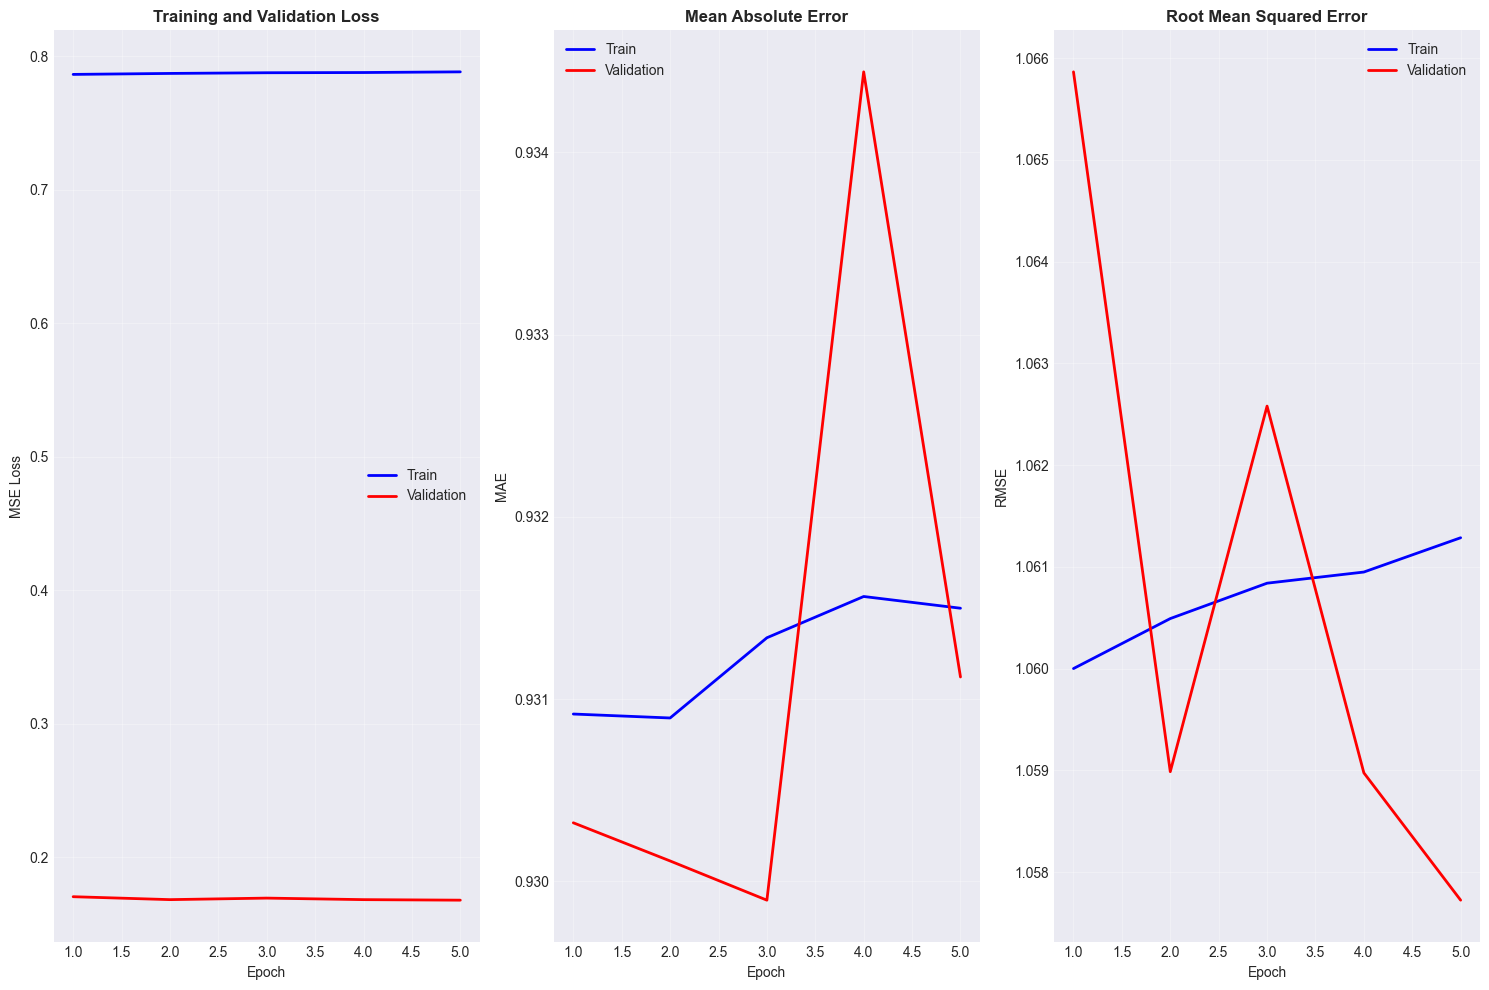

✅ Saved to 'training_results/training_progress.png'


In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training and Validation Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(epochs_range, history['train_mae'], 'b-', label='Train', linewidth=2)
axes[1].plot(epochs_range, history['val_mae'], 'r-', label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Mean Absolute Error', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# RMSE
axes[2].plot(epochs_range, history['train_rmse'], 'b-', label='Train', linewidth=2)
axes[2].plot(epochs_range, history['val_rmse'], 'r-', label='Validation', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('RMSE')
axes[2].set_title('Root Mean Squared Error', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_progress.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved to '{OUTPUT_DIR}/training_progress.png'")

## Part 10: Test Set Evaluation

In [31]:
print("=" * 80)
print("Evaluating on Test Set")
print("=" * 80)

test_loss, test_mae, test_rmse, test_r2, test_preds, test_targets, test_cif_ids = validate_epoch(
    model, test_loader, criterion, device
)

print(f"\n📊 Test Set Performance:")
print(f"   Loss (MSE): {test_loss:.6f}")
print(f"   MAE:        {test_mae:.6f}")
print(f"   RMSE:       {test_rmse:.6f}")
print(f"   R² Score:   {test_r2:.4f}")

# Save results
test_results = pd.DataFrame({
    'material_id': test_cif_ids,
    'true_value': test_targets,
    'predicted_value': test_preds,
    'error': np.array(test_targets) - np.array(test_preds),
    'abs_error': np.abs(np.array(test_targets) - np.array(test_preds))
})

test_results_sorted = test_results.sort_values('abs_error', ascending=False)
test_results.to_csv(os.path.join(OUTPUT_DIR, 'test_results.csv'), index=False)

print(f"\n📋 Top 5 Best Predictions:")
print(test_results_sorted.tail(5)[['material_id', 'true_value', 'predicted_value', 'abs_error']])

print(f"\n⚠️ Top 5 Worst Predictions:")
print(test_results_sorted.head(5)[['material_id', 'true_value', 'predicted_value', 'abs_error']])

print(f"\n✅ Test results saved to '{OUTPUT_DIR}/test_results.csv'")

Evaluating on Test Set


Validation:   0%|                                                                                                  | 0/1944 [00:00<?, ?it/s]C:\Users\abhin\Desktop\cgcnn\.venv\Lib\site-packages\pymatgen\core\structure.py:3109: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
Validation:   0%|                                                                               | 2/1944 [00:00<11:09,  2.90it/s, loss=1.18]C:\Users\abhin\Desktop\cgcnn\.venv\Lib\site-packages\pymatgen\core\structure.py:3109: UserWarning: Issues encountered while parsing CIF: 1 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
Validation:   0%|▏                                                                              | 5/1944 [00:02<15:16,  2.12it/s, loss=1.25]C:\Users\abh


📊 Test Set Performance:
   Loss (MSE): 0.166959
   MAE:        0.932250
   RMSE:       1.055038
   R² Score:   -0.0000

📋 Top 5 Best Predictions:
      material_id  true_value  predicted_value  abs_error
5894   mp-1233948   -1.660259        -1.659216   0.001043
14171   mp-560149   -1.660051        -1.659216   0.000836
9825   mp-1025029   -1.659885        -1.659216   0.000670
10816   mp-542813   -1.658623        -1.659216   0.000593
4473     mp-23897   -1.659275        -1.659216   0.000059

⚠️ Top 5 Worst Predictions:
      material_id  true_value  predicted_value  abs_error
13240    mp-22072   -4.524320        -1.659216   2.865104
14048   mp-675492   -4.446303        -1.659216   2.787088
8752      mp-2651   -4.436969        -1.659216   2.777754
150      mp-31034   -4.425086        -1.659216   2.765871
5107   mp-1228137   -4.374406        -1.659216   2.715190

✅ Test results saved to 'training_results/test_results.csv'


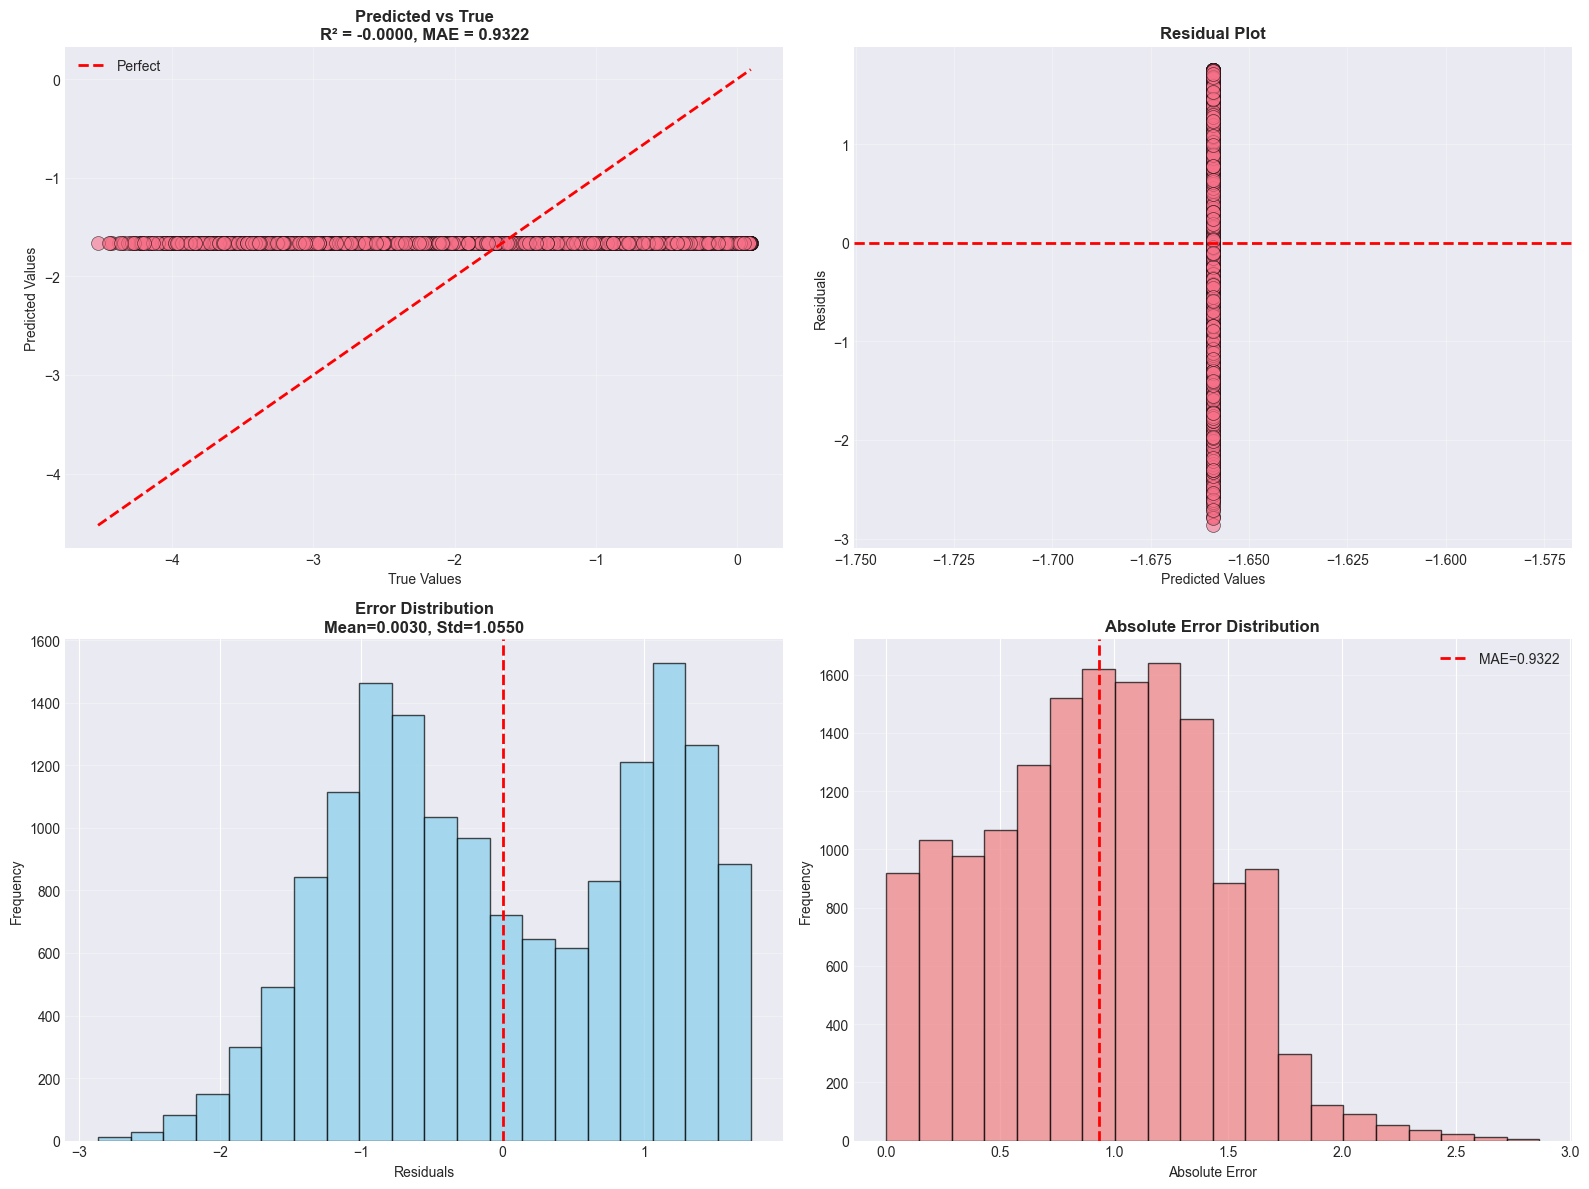

✅ Saved to 'training_results/prediction_analysis.png'


In [32]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Predicted vs True
axes[0, 0].scatter(test_targets, test_preds, alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
axes[0, 0].plot([min(test_targets), max(test_targets)], [min(test_targets), max(test_targets)], 
                'r--', linewidth=2, label='Perfect')
axes[0, 0].set_xlabel('True Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title(f'Predicted vs True\nR² = {test_r2:.4f}, MAE = {test_mae:.4f}', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Residuals
residuals = np.array(test_targets) - np.array(test_preds)
axes[0, 1].scatter(test_preds, residuals, alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Error distribution
axes[1, 0].hist(residuals, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Error Distribution\nMean={np.mean(residuals):.4f}, Std={np.std(residuals):.4f}', 
                     fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Absolute error
abs_errors = np.abs(residuals)
axes[1, 1].hist(abs_errors, bins=20, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1, 1].axvline(x=test_mae, color='r', linestyle='--', linewidth=2, label=f'MAE={test_mae:.4f}')
axes[1, 1].set_xlabel('Absolute Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Absolute Error Distribution', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'prediction_analysis.png'), dpi=300, bbox_inches='tight')
plt.show() 

print(f"✅ Saved to '{OUTPUT_DIR}/prediction_analysis.png'")

## Summary

✅ **Training Complete!**

All results have been saved to the `training_results/` directory:
- `best_model.pth`: Best model checkpoint
- `training_history.csv`: Training metrics over epochs
- `test_results.csv`: Detailed test predictions
- `performance_summary.csv`: Final metrics summary
- `training_progress.png`: Training curves
- `prediction_analysis.png`: Prediction visualizations
- `performance_comparison.png`: Performance comparison

---